In [1]:
import gradio as gr
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image, ImageEnhance
from itertools import permutations, combinations
import numpy as np
import uuid

In [2]:
from roboflow import Roboflow
rf = Roboflow(api_key="Q0EN6hdjVCdwqJnAAYvc")
project = rf.workspace().project("playing-cards-ow27d")
model = project.version(2).model

loading Roboflow workspace...
loading Roboflow project...


In [3]:
path_52cards = "52cards/"
prefix = "800px-Playing_card_"
suffix = ".svg.png"

In [16]:
suits = {"spade":0, "club":1, "diamond":2, "heart":3}
numbs = {"blank":1, "2":2, "3":3, "4":4, "5":5, "6":6, "7":7, "8":8,
         "9":9, "10":10, "J":11, "Q":12, "K":13, "A":14}

ranks = {
    "high_card": 0,
    "pair": 1,
    "two_pairs": 2,
    "three_of_a_kind": 3,
    "straight": 4,
    "flush": 5,
    "full_house": 6,
    "four_of_a_kind": 7,
    "straight_flush": 8,
}

A2345_combo = list(permutations(["A", "2", "3", "4", "5"]))
all_of_straights = list(permutations(["2", "3", "4", "5", "6"]))
all_of_straights += list(permutations(["3", "4", "5", "6", "7"]))
all_of_straights += list(permutations(["4", "5", "6", "7", "8"]))
all_of_straights += list(permutations(["5", "6", "7", "8", "9"]))
all_of_straights += list(permutations(["6", "7", "8", "9", "10"]))
all_of_straights += list(permutations(["7", "8", "9", "10", "J"]))
all_of_straights += list(permutations(["8", "9", "10", "J", "Q"]))
all_of_straights += list(permutations(["9", "10", "J", "Q", "K"]))
all_of_straights += list(permutations(["10", "J", "Q", "K", "A"]))

all_of_straights_3ele = list(permutations(["A", "2", "3"]))
all_of_straights_3ele += list(permutations(["2", "3", "4"]))
all_of_straights_3ele += list(permutations(["3", "4", "5"]))
all_of_straights_3ele += list(permutations(["4", "5", "6"]))
all_of_straights_3ele += list(permutations(["5", "6", "7"]))
all_of_straights_3ele += list(permutations(["6", "7", "8"]))
all_of_straights_3ele += list(permutations(["7", "8", "9"]))
all_of_straights_3ele += list(permutations(["8", "9", "10"]))
all_of_straights_3ele += list(permutations(["9", "10", "J"]))
all_of_straights_3ele += list(permutations(["10", "J", "Q"]))
all_of_straights_3ele += list(permutations(["J", "Q", "K"]))
all_of_straights_3ele += list(permutations(["Q", "K", "A"]))


def card_split(suit_card):
    tmp = suit_card.split("_")
    return tmp[0], tmp[1]


def straight_flush(combo):
    if (combo not in all_of_straights) and (combo not in A2345_combo):
        return None
    
    su, nu = card_split(combo[-1])
    for card in combo[:-1]:
        su_, nu_ = card_split(card)
        if su_ != su:
            return None
    if combo in A2345_combo:
        return "5"
    return nu


def four_of_a_kind(hands):
    count_ = dict()
    for card in hands:
        s, c = card_split(card)
        if c not in count_.keys():
            count_[c] = 1
        else:
            count_[c] += 1
    kind = None
    for key, value in count_.items():
        if value == 4:
            if kind == None:
                kind = key
            elif numbs[key] > numbs[kind]:
                kind = key
    return kind


def identify_combo(combo):
    if len(combo) == 3:
        card_1, card_2 = "blank", "blank"
        card_3, card_4, card_5 = combo
        s1, n1 = None, None
        s2, n2 = None, None
    else:
        card_1, card_2, card_3, card_4, card_5 = combo
        s1, n1 = card_split(card_1)
        s2, n2 = card_split(card_2)
    
    s3, n3 = card_split(card_3)
    s4, n4 = card_split(card_4)
    s5, n5 = card_split(card_5)
    
    # Full House --------------------------------|
    if n1 == n2 == n3 and n4 == n5:
        return "full_house", n3, None, None, None, None
    if n1 == n2 and n3 == n4 == n5:
        return "full_house", n5, None, None, None, None
    
    # Flush -------------------------------------|
    if s1 == s2 == s3 == s4 == s5:
        return "flush", n5, n4, n3, n2, n1
    
    # Straight ----------------------------------|
    if combo in A2345_combo:
        return "straight", n4, None, None, None, None # it means that combo is 2-3-4-5-A
    if combo in all_of_straights:
        return "straight", n5, None, None, None, None
    
    # Three of a kind ---------------------------|
    if n1 == n2 == n3:
        return "three_of_a_kind", n3, None, None, None, None
    if n2 == n3 == n4:
        return "three_of_a_kind", n4, None, None, None, None
    if n3 == n4 == n5:
        return "three_of_a_kind", n5, None, None, None, None
    
    # Two pairs ---------------------------------|
    if n1 == n2 and n1 != None:
        if n3 == n4:
            return "two_pairs", n4, n2, n5, None, None
        if n4 == n5:
            return "two_pairs", n5, n2, n3, None, None
    else:
        if n2 == n3 and n4 == n5:
            return "two_pairs", n5, n3, n1, None, None
    
    # Pair --------------------------------------|
    if n1 == n2 and n1 != None:
        return "pair", n2, n5, n4, n3, None
    if n2 == n3:
        return "pair", n3, n5, n4, n1, None
    if n3 == n4:
        return "pair", n4, n5, n2, n1, None
    if n4 == n5:
        return "pair", n5, n3, n2, n1, None
    
    # High card ---------------------------------|
    return "high_card", n5, n4, n3, n2, n1


def numbs_comparison(n1, n2):
    if n1 == n2 == None:
        return 0
    if n1 == None:
        return -1
    if n2 == None:
        return 1
    
    if numbs[n1] < numbs[n2]:
        return -1
    if numbs[n1] > numbs[n2]:
        return 1
    return 0
    

def comboes_comparison(combo_1, combo_2):
    identify_1, r11, r12, r13, r14, r15 = identify_combo(combo_1)
    identify_2, r21, r22, r23, r24, r25 = identify_combo(combo_2)
    i_in_1 = ranks[identify_1]
    i_in_2 = ranks[identify_2]
    if i_in_1 > i_in_2:
        return 1
    if i_in_1 < i_in_2:
        return -1
    
    if identify_1 == "full_house":
        return numbs_comparison(r11, r21)
    
    if identify_1 == "flush":
        comp_1 = numbs_comparison(r11, r21)
        if comp_1 != 0:
            return comp_1
        comp_2 = numbs_comparison(r12, r22)
        if comp_2 != 0:
            return comp_2
        comp_3 = numbs_comparison(r13, r23)
        if comp_3 != 0:
            return comp_3
        comp_4 = numbs_comparison(r14, r24)
        if comp_4 != 0:
            return comp_4
        return numbs_comparison(r15, r25)
    
    if identify_1 == "straight":
        return numbs_comparison(r11, r21)
        
    if identify_1 == "three_of_a_kind":
        return numbs_comparison(r11, r21)
    
    if identify_1 == "two_pairs":
        comp_1 = numbs_comparison(r11, r21)
        if comp_1 != 0:
            return comp_1
        comp_2 = numbs_comparison(r12, r22)
        if comp_2 != 0:
            return comp_2
        return numbs_comparison(r13, r23)
    
    if identify_1 == "pair":
        comp_1 = numbs_comparison(r11, r21)
        if comp_1 != 0:
            return comp_1
        comp_2 = numbs_comparison(r12, r22)
        if comp_2 != 0:
            return comp_2
        comp_3 = numbs_comparison(r13, r23)
        if comp_3 != 0:
            return comp_3
        return numbs_comparison(r14, r24)
    
    # identify_1 == "high card"
    comp_1 = numbs_comparison(r11, r21)
    if comp_1 != 0:
        return comp_1
    comp_2 = numbs_comparison(r12, r22)
    if comp_2 != 0:
        return comp_2
    comp_3 = numbs_comparison(r13, r23)
    if comp_3 != 0:
        return comp_3
    comp_4 = numbs_comparison(r14, r24)
    if comp_4 != 0:
        return comp_4
    return numbs_comparison(r15, r25)


def hands_comparison(hands_1, hands_2):
    combo_1_1, combo_1_2, combo_1_3 = hands_1
    combo_2_1, combo_2_2, combo_2_3 = hands_2
    value = comboes_comparison(combo_1_1, combo_2_1)
    value += comboes_comparison(combo_1_2, combo_2_2)
    value += comboes_comparison(combo_1_3, combo_2_3)
    return value


def permutations_553(hands):
    perm_553 = []
    comboes_1 = list(combinations(hands, 5))
    for c1, c2, c3, c4, c5 in comboes_1:
        combo_1 = (c1, c2, c3, c4, c5)
        tmp_hands = hands.copy()
        tmp_hands.remove(c1)
        tmp_hands.remove(c2)
        tmp_hands.remove(c3)
        tmp_hands.remove(c4)
        tmp_hands.remove(c5)
        
        comboes_2 = list(combinations(tmp_hands, 5))
        for c6, c7, c8, c9, c10 in comboes_2:
            combo_2 = (c6, c7, c8, c9, c10)

            combo_3 = tmp_hands.copy()
            combo_3.remove(c6)
            combo_3.remove(c7)
            combo_3.remove(c8)
            combo_3.remove(c9)
            combo_3.remove(c10)
            combo_3 = tuple(combo_3)

            if comboes_comparison(combo_1, combo_2) > 0 and comboes_comparison(combo_2, combo_3) > 0:
                vip_hands = [combo_1, combo_2, combo_3]
                perm_553.append(vip_hands)

    return perm_553


def n_largest(a):
    b1 = [0] * len(a)
    for i in range(0, len(a)-1):
        for j in range(i+1, len(a)):
            tmp = hands_comparison(a[i], a[j])
            b1[i] += tmp // np.abs(tmp)
            b1[j] -= tmp // np.abs(tmp)
            
    b1 = np.array(b1)
    n_top = 7
    ind = np.argpartition(b1, -n_top)[-n_top:]

    top_10 = b1[ind]
    for i in range(0, n_top-1):
        for j in range(0, n_top-i-1):
            if top_10[j] < top_10[j+1]:
                top_10[j], top_10[j+1] = top_10[j+1], top_10[j]
                ind[j], ind[j+1] = ind[j+1], ind[j]
            if top_10[j] == top_10[j+1]:
                if hands_comparison(a[j], a[j+1]) < 0:
                    top_10[j], top_10[j+1] = top_10[j+1], top_10[j]
                    ind[j], ind[j+1] = ind[j+1], ind[j]

    tmp = [_/(len(a)-1) for _ in top_10]

    return np.array(a)[ind], tmp


def cards_comparison(card_1, card_2):
    s1, c1 = card_split(card_1)
    s2, c2 = card_split(card_2)
    c_in_1, c_in_2 = numbs[c1], numbs[c2]
    if c_in_1 > c_in_2:
        return 1
    if c_in_1 < c_in_2:
        return -1
    # c_in_1 == c_in_2:
    s_in_1, s_in_2 = suits[s1], suits[s2]
    if s_in_1 > s_in_2:
        return 1
    if s_in_1 < s_in_2:
        return -1
    return 0


def sort_n2(a):
    for i in range(0, len(a)-1):
        for j in range(i+1, len(a)):
            if cards_comparison(a[i], a[j]) > 0:
                a[i], a[j] = a[j], a[i]

In [17]:
hands = ['diamond_5', 'heart_8', 'club_3', 'heart_2', 'club_8', 'diamond_10', 'heart_Q', 'diamond_3', 'spade_Q', 'diamond_4', 'diamond_Q', 'diamond_9', 'diamond_K']
sort_n2(hands)

In [25]:
test_path = "xapxam/test/"
results_path = "xapxap/results/"

def show_hand(hand, result_path):
    fig = plt.figure(figsize=(12, 12))
    columns, rows = 5, 3
    for i in range(2):
        for j in range(5):
            card = hand[i][j]
            card_path = path_52cards + prefix + card + suffix
            img = mpimg.imread(card_path)
            fig.add_subplot(rows, columns, i*5 + j + 1)
            plt.axis("off")
            plt.imshow(img)
    i = 2
    blank_path = path_52cards + "blank.png"
    img = mpimg.imread(blank_path)
    fig.add_subplot(rows, columns, i*5 + 0 + 1)
    fig.add_subplot(rows, columns, i*5 + 4 + 1)
    plt.axis("off")
    plt.imshow(img)
    for j in range(1, 3+1):
        card = hand[i][j-1]
        card_path = path_52cards + prefix + card + suffix
        img = mpimg.imread(card_path)
        fig.add_subplot(rows, columns, i*5 + j + 1)
        plt.axis("off")
        plt.imshow(img)
    
    fig.savefig(result_path)
    im = Image.open(result_path)
    plt.axis("off")
    plt.show()
    return im
    

def flip(img):
    uuid_generator = str(uuid.uuid4())
    image_path = test_path + uuid_generator + ".jpg"
    result_path = results_path + uuid_generator + ".jpg"
    
    width, height = img.size
    if width == 0 or height == 0:
        return img
    if height > 800:
        width = width * 800 // height
        height = 800
        img = img.resize((width, height))
    
#     enhancer = ImageEnhance.Brightness(img)
#     factor = 1.0
#     img = enhancer.enhance(factor)
    
    img_save = img.save(image_path)
    infer_on_a_local_image = model.predict(image_path, confidence=50, overlap=50).json()
    
    predictions = infer_on_a_local_image["predictions"]
    
    preds = sorted(predictions, key=lambda d: d['confidence'], reverse=True)
    
    classes = []
    for ele in preds:
        print(ele["class"], ele["confidence"])
        if ele["class"] not in classes:
            classes.append(ele["class"])
        if len(classes) == 13:
            break
    if len(classes) < 13:
        return img
    
    hands = []
    for cl in classes:
        card = cl[:-1]
        if cl[-1] == "S":
            card = "spade_" + card
        elif cl[-1] == "C":
            card = "club_" + card
        elif cl[-1] == "D":
            card = "diamond_" + card
        elif cl[-1] == "H":
            card = "heart_" + card
        hands.append(card)
    print(hands)
    return img

    
    kind = four_of_a_kind(hands)
    if kind:
        fig = plt.figure(figsize=(12, 3))
        four = [_ + "_" + kind for _ in suits.keys()]
        for i, card in enumerate(four):
            card_path = path_52cards + prefix + card + suffix
            img = mpimg.imread(card_path)
            fig.add_subplot(1, 4, i+1)
            plt.axis("off")
            plt.imshow(img)
        fig.savefig(result_path)
        im = Image.open(result_path)
        plt.axis("off")
        plt.show()
        return im
    
    all_hands = permutations_553(hands)
    n_lar, scores = n_largest(all_hands)
    try:
        for hand, score in zip(n_lar, scores):
            im = show_hand(hand, result_path)
            break
    except Exception as e:
        print(e)
        im = img
    return im

In [20]:
all_hands = permutations_553(hands)

NameError: name 'result_path' is not defined

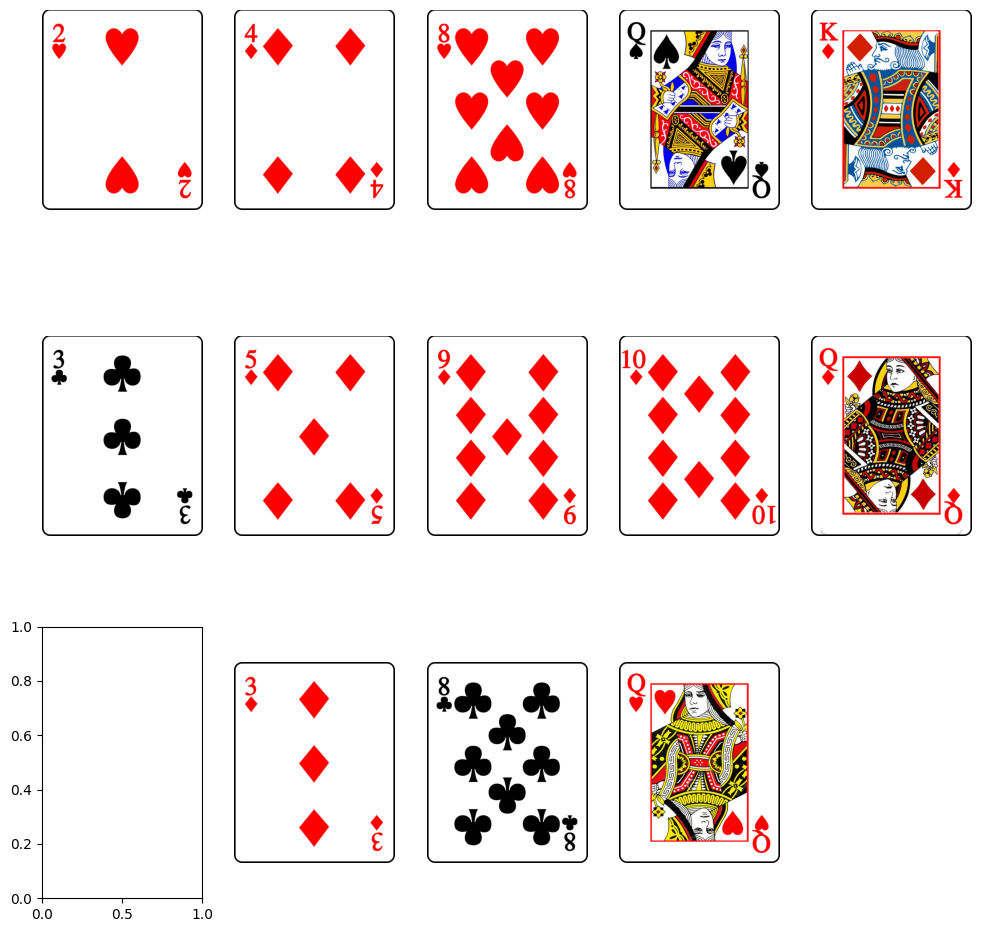

In [26]:
hand = all_hands[3105]
fig = plt.figure(figsize=(12, 12))
columns, rows = 5, 3
for i in range(2):
    for j in range(5):
        card = hand[i][j]
        card_path = path_52cards + prefix + card + suffix
        img = mpimg.imread(card_path)
        fig.add_subplot(rows, columns, i*5 + j + 1)
        plt.axis("off")
        plt.imshow(img)
i = 2
blank_path = path_52cards + "blank.png"
img = mpimg.imread(blank_path)
fig.add_subplot(rows, columns, i*5 + 0 + 1)
fig.add_subplot(rows, columns, i*5 + 4 + 1)
plt.axis("off")
plt.imshow(img)
for j in range(1, 3+1):
    card = hand[i][j-1]
    card_path = path_52cards + prefix + card + suffix
    img = mpimg.imread(card_path)
    fig.add_subplot(rows, columns, i*5 + j + 1)
    plt.axis("off")
    plt.imshow(img)

fig.savefig(result_path)
im = Image.open(result_path)
plt.axis("off")
plt.show()

In [21]:
len(all_hands)

22323

In [19]:
all_hands = permutations_553(hands)
n_lar, scores = n_largest(all_hands)
try:
    for hand, score in zip(n_lar, scores):
        im = show_hand(hand, result_path)
        break
except Exception as e:
    print(e)
    im = img

divide by zero encountered in scalar floor_divide
divide by zero encountered in scalar floor_divide


KeyboardInterrupt: 

In [7]:
# demo = gr.Interface(
#     flip, 
#     inputs=[gr.inputs.Image(type="pil", label="Input Image", source="webcam"),], 
#     outputs="image",
#     live=True
# )

demo = gr.Interface(
    flip, 
    inputs=[gr.inputs.Image(type="pil", label="Input Image"),], 
    outputs="image",
)

demo.launch(share=True)

Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
`optional` parameter is deprecated, and it has no effect


Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://984569d4-ab87-42c8.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


5D 0.9435470700263977
8H 0.9386656880378723
3C 0.9233882427215576
2H 0.9212188720703125
8C 0.9165587425231934
10D 0.9103370308876038
QH 0.907417893409729
3D 0.9073491096496582
QS 0.904944658279419
4D 0.9034665822982788
QD 0.8989407420158386
9D 0.8907375931739807
KD 0.883826732635498
['diamond_5', 'heart_8', 'club_3', 'heart_2', 'club_8', 'diamond_10', 'heart_Q', 'diamond_3', 'spade_Q', 'diamond_4', 'diamond_Q', 'diamond_9', 'diamond_K']


In [25]:
import shutil
import os

if os.path.exists(test_path):
    shutil.rmtree(test_path)
if os.path.exists(results_path):
    shutil.rmtree(results_path)

os.mkdir(test_path)
os.mkdir(results_path)

In [22]:
from math import comb
comb(52-9, 9)

563921995